In [2]:
import tifffile
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit
from scipy import interpolate

In [3]:
def get_projection(img, iso_dimension=-1):
    list_dimensions = [-1, -2, -3]
    list_dimensions.remove(iso_dimension)
    if isinstance(img, np.ndarray):
        img_iso = np.max(img, axis=iso_dimension)
        img_aniso0 = np.max(img, axis=list_dimensions[0])
        img_aniso1 = np.max(img, axis=list_dimensions[1])
    elif isinstance(img, torch.Tensor):
        img_iso = torch.max(img, dim=iso_dimension).values
        img_aniso0 = torch.max(img, dim=list_dimensions[0]).values
        img_aniso1 = torch.max(img, dim=list_dimensions[1]).values
    return img_iso, img_aniso0, img_aniso1

In [4]:
input_img = tifffile.imread('./dataset/img_test/inputtest.tif')
selfnet_img = tifffile.imread('./dataset/img_test/out__fusion__test.tif')
MPCN_img = tifffile.imread('./dataset/img_test/outputtest.tif')

FileNotFoundError: [Errno 2] No such file or directory: '/share/home/wangwb/workspace/sr_3dunet/scripts/get_paper_picture/dataset/img_test/inputtest.tif'

Text(0.5, 1.0, 'MPCN_img_anisoMIP_1')

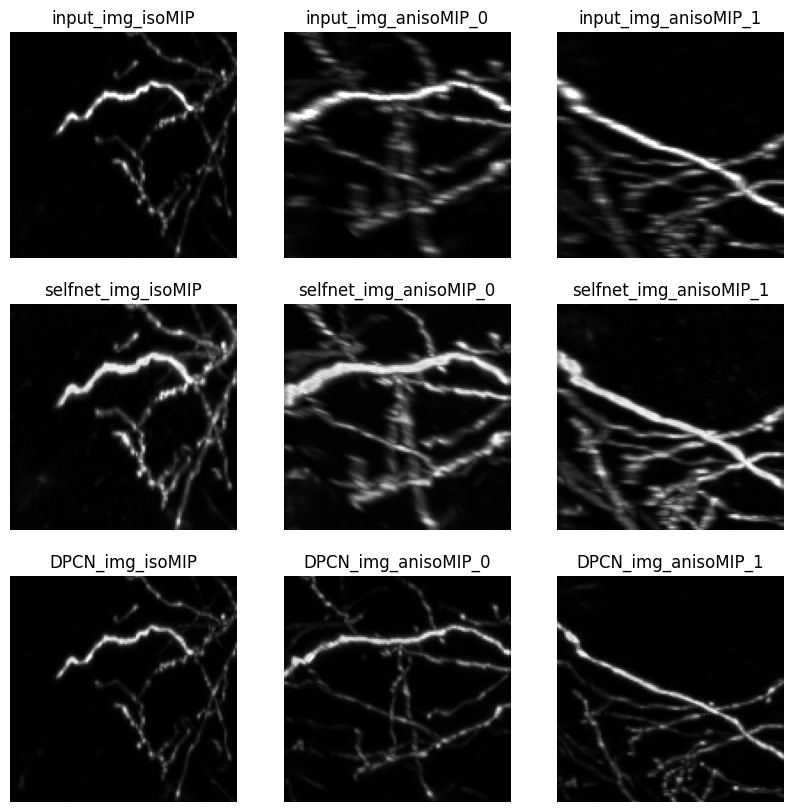

In [5]:
plt.figure(figsize=(10, 10))

input_img_iso, input_img_aniso0, input_img_aniso1 = get_projection(input_img)
selfnet_img_iso, selfnet_img_aniso0, selfnet_img_aniso1 = get_projection(selfnet_img)
MPCN_img_iso, MPCN_img_aniso0, MPCN_img_aniso1 = get_projection(MPCN_img)

plt.subplot(3,3,1)
plt.imshow(input_img_iso, cmap='gray')
plt.axis('off')
plt.title('input_img_isoMIP')

plt.subplot(3,3,2)
plt.imshow(input_img_aniso0, cmap='gray')
plt.axis('off')
plt.title('input_img_anisoMIP_0')

plt.subplot(3,3,3)
plt.imshow(input_img_aniso1, cmap='gray')
plt.axis('off')
plt.title('input_img_anisoMIP_1')

plt.subplot(3,3,4)
plt.imshow(selfnet_img_iso, cmap='gray')
plt.axis('off')
plt.title('selfnet_img_isoMIP')

plt.subplot(3,3,5)
plt.imshow(selfnet_img_aniso0, cmap='gray')
plt.axis('off')
plt.title('selfnet_img_anisoMIP_0')

plt.subplot(3,3,6)
plt.imshow(selfnet_img_aniso1, cmap='gray')
plt.axis('off')
plt.title('selfnet_img_anisoMIP_1')

plt.subplot(3,3,7)
plt.imshow(MPCN_img_iso, cmap='gray')
plt.axis('off')
plt.title('MPCN_img_isoMIP')

plt.subplot(3,3,8)
plt.imshow(MPCN_img_aniso0, cmap='gray')
plt.axis('off')
plt.title('MPCN_img_anisoMIP_0')

plt.subplot(3,3,9)
plt.imshow(MPCN_img_aniso1, cmap='gray')
plt.axis('off')
plt.title('MPCN_img_anisoMIP_1')

C:\Users\WangW\AppData\Local\Temp\ipykernel_51312\4042764685.py:15: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return a*exp(-(x-x0)**2/(2*sigma**2))


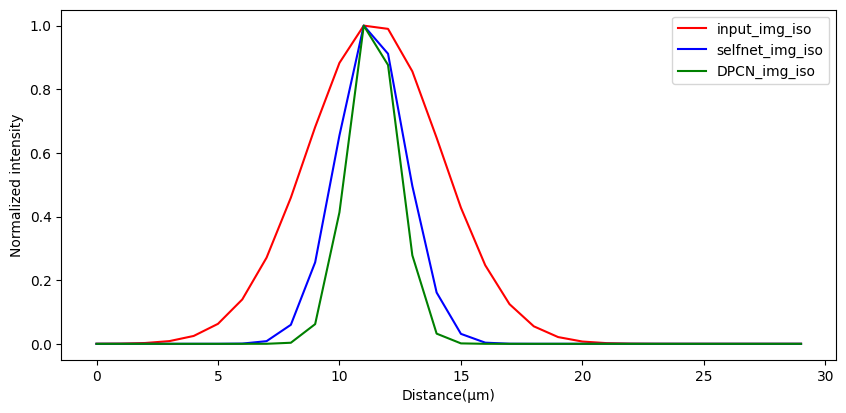

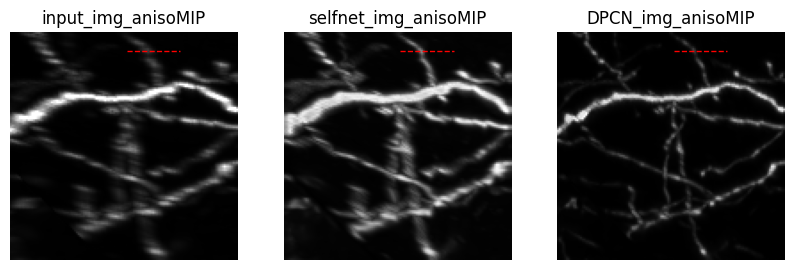

In [23]:
# Increase y
start_x = 65
start_y = 10 # 110

# size = 64
len_ = 30

def norm_list(input_list):
    output_list = (input_list - np.min(input_list)) / (np.max(input_list) - np.min(input_list))
    return output_list

def gaussian_fit(list_coor, list_val):

    def gaus(x,a,x0,sigma):
        return a*exp(-(x-x0)**2/(2*sigma**2))

    def getmean_and_sigma(list_coor, list_val):
        x = np.asarray(range(len(list_coor)))
        y = list_val
        mean = sum(x * y)
        sigma = sum(y*(x-mean)**2)/len(list_coor)
        return mean,sigma
    
    list_val = norm_list(list_val)
    mean, sigma = getmean_and_sigma(list_coor, list_val)
    popt, pcov = curve_fit(gaus, list_coor,list_val,p0=[1, mean, sigma])
    list_val = gaus(list_coor,*popt)
    list_val = norm_list(list_val)
    
    return list_coor, list_val

def get_listxy(img):
    list_coor = list(range(0,len_))
    list_val = img[start_y, start_x:start_x+len_]
    return list_coor, list_val

def plt_img():
    plt.figure(figsize=(10, 10))
    plt.subplot(211)
    
    list_x, list_y_input = get_listxy(input_img_aniso0)
    list_x, list_y_input = gaussian_fit(list_x, list_y_input)
    plt.plot(list_x, list_y_input, color='red', label='input_img_iso')

    list_x, list_y_selfnet = get_listxy(selfnet_img_aniso0)
    list_x, list_y_selfnet = gaussian_fit(list_x, list_y_selfnet)
    plt.plot(list_x, list_y_selfnet, color='blue', label='selfnet_img_iso')

    list_x, list_y_MPCN = get_listxy(MPCN_img_aniso0)
    list_x, list_y_MPCN = gaussian_fit(list_x, list_y_MPCN)
    plt.plot(list_x, list_y_MPCN, color='green', label='MPCN_img_iso')

    plt.legend()
    plt.xlabel("Distance(μm)")
    plt.ylabel("Normalized intensity")
    plt.show()
    
    plt.figure(figsize=(10, 10))
    plt.subplot(234)
    plt.imshow(input_img_aniso0, cmap='gray')
    plt.plot([start_x, start_x + len_], [start_y, start_y], color='red', linewidth=1, linestyle='dashed')
    plt.axis('off')
    plt.title('input_img_anisoMIP')
    
    plt.subplot(235)
    plt.imshow(selfnet_img_aniso0, cmap='gray')
    plt.plot([start_x, start_x + len_], [start_y, start_y], color='red', linewidth=1, linestyle='dashed')
    plt.axis('off')
    plt.title('selfnet_img_anisoMIP')
    
    plt.subplot(236)
    plt.imshow(MPCN_img_aniso0, cmap='gray')
    plt.plot([start_x, start_x + len_], [start_y, start_y], color='red', linewidth=1, linestyle='dashed')
    plt.axis('off')
    plt.title('MPCN_img_anisoMIP')
    
plt_img()